# CMU notebook
Before you turn these assignments in, make sure everything runs as expected. Be sure to click **run all** (in the upper right).

Follow the guide and fill in any place that says `YOUR CODE/ANSWER HERE` or `TODO`.

# CMU Machine Learning with Large Datasets

## Homework 4 - Programming 2: Fine-tuning BERT

In [1]:
# Who did you collaborate with on this assignment?
# if no one, collaborators should contain an empty string,
# else list your collaborators below
collaborators = [""]

In [2]:
try:
    collaborators
except:
    raise AssertionError("you did not list your collaborators, if any")

## **0. Preliminaries**

You do not need to modify this part.

In [3]:
# Run this cell on Colab to install the required packages
!pip install --quiet transformers datasets peft accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Import necessary libraries

import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

from transformers import BertTokenizerFast, BertForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

import unittest

In [5]:
# Fix the seed and define the device

seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [6]:
# Load and Preprocess the Dataset

dataset = load_dataset('SetFit/sst5')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

encoded_dataset = dataset.map(lambda examples: tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128), batched=True)
encoded_dataset = encoded_dataset.rename_column('label', 'labels')
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

batch_size = 64

train_dataloader = DataLoader(encoded_dataset['train'], batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(encoded_dataset['validation'], batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/421 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/171k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [7]:
# Useful helper functions for you to use

def get_model_params_info(model):
    # Total number of parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Number of trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Portion of trainable to all parameters
    portion_trainable = trainable_params / total_params if total_params > 0 else 0

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Portion of trainable to all parameters: {portion_trainable:.4f}")

    return total_params, trainable_params, portion_trainable

def train_one_step(model, loss_fn, optimizer, dataloader, t="hf"):
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if t == "hf":
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        else:
            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        dataloader.set_postfix({'loss': loss.item()})

    return total_loss / len(train_dataloader)


def eval_model(model, dataloader, t='hf'):
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in eval_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            if t == 'hf':
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)
                predictions = predictions.cpu().numpy()
            else:
                logits = model(input_ids)
                logits = logits.detach().cpu().numpy()
                predictions = np.argmax(logits, axis=1).flatten()

            preds.extend(predictions)
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')

    return accuracy, f1

## 1. Implemeting LoRA

<!-- Your task is to fine-tune the **Llama2** model for sentiment analysis using the **SST-5** dataset. This involves implementing and experimenting with various fine-tuning methods. You will need to track and compare the model's performance and memory usage across different methods.

You only need to modify this notebook. -->

Before proceeding with the implementation, please refer to the following resources for a deeper understanding of LoRA:

- **LoRA Paper**: [https://arxiv.org/abs/2106.09685](https://arxiv.org/abs/2106.09685)
- **Video Explainer**: [https://www.youtube.com/watch?v=DhRoTONcyZE](https://www.youtube.com/watch?v=DhRoTONcyZE)

It is recommended that you review these materials before beginning the implementation.

In this assignment, you should initialize A as:
$A = \frac{1}{\sqrt{r}} \cdot \mathcal{N}(0, 1)$ (you can use `torch.randn`), and B as zero matrix.



In [8]:
class MyLoraConfig:
    def __init__(self, r, target_modules, lora_alpha, lora_dropout):
        self.r = r
        self.target_modules = target_modules
        self.lora_alpha = lora_alpha
        self.lora_dropout = lora_dropout


class MyLoraLayer(nn.Module):
    def __init__(self, base_layer, r, lora_alpha, lora_dropout):
        super(MyLoraLayer, self).__init__()

        self.base_layer = base_layer
        self.r = r
        self.lora_alpha = float(lora_alpha)

        # Check if the base layer has weight attribute
        if hasattr(base_layer, 'weight'):
            base_layer.weight.requires_grad = False

            # Create low-rank adaptation matrices
            self.lora_A = nn.Linear(base_layer.in_features, r, bias=False)
            # Initialize A with normal distribution scaled by 1/sqrt(r)
            nn.init.normal_(self.lora_A.weight, mean=0, std=1 / math.sqrt(r))

            # For the B matrix, initialize with zeros
            self.lora_B = nn.Linear(r, base_layer.out_features, bias=False)
            nn.init.zeros_(self.lora_B.weight)

            # Create dropout layer
            self.lora_dropout = nn.Dropout(p=lora_dropout, inplace=False)

            # Scaling factor for the LoRA path
            self.scaling = self.lora_alpha / self.r
        else:
            # If no weight attribute, just maintain the original layer without LoRA
            self.lora_A = None
            self.lora_B = None
            self.lora_dropout = None
            self.scaling = 0

    def forward(self, x):
        # Original output from the base layer
        base_output = self.base_layer(x)

        # Apply LoRA path if available
        if self.lora_A is not None:
            lora_output = self.lora_B(self.lora_A(self.lora_dropout(x)))
            return base_output + lora_output * self.scaling
        else:
            return base_output

In [9]:
# Test LoRA implementation.

class TestMyLoraLayer(unittest.TestCase):

    def test_init(self):
        seed = 1337
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        base_layer = nn.Linear(4, 5)
        lora_layer = MyLoraLayer(base_layer, r=2, lora_alpha=4, lora_dropout=0.1)

        # base check
        self.assertEqual(lora_layer.r, 2)
        self.assertEqual(lora_layer.lora_alpha, 4.0)
        self.assertEqual(lora_layer.lora_dropout.p, 0.1)

        # test dimension
        self.assertEqual(lora_layer.lora_A.in_features, 4)
        self.assertEqual(lora_layer.lora_A.out_features, 2)
        self.assertEqual(lora_layer.lora_B.in_features, 2)
        self.assertEqual(lora_layer.lora_B.out_features, 5)

        # test initialization
        ref_a = torch.tensor([[ 0.6689, -0.2572, -1.8404,  0.8856],
                              [-0.1736, -0.2809, -0.6725, -0.4549]])
        self.assertTrue(torch.allclose(lora_layer.lora_A.weight.data, ref_a, atol=1e-4, rtol=1e-3))
        ref_b = torch.tensor([[0., 0.],
                              [0., 0.],
                              [0., 0.],
                              [0., 0.],
                              [0., 0.]])
        self.assertTrue(torch.allclose(lora_layer.lora_B.weight.data, ref_b, atol=1e-4, rtol=1e-3))

    def test_forward(self):
        seed = 1337
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        base_layer = nn.Linear(4, 5)
        lora_layer = MyLoraLayer(base_layer, r=2, lora_alpha=4, lora_dropout=0.1)
        lora_layer.lora_B.weight.data = torch.tensor([[0.142, 0.353],
                                                      [0.471, 0.946],
                                                      [0.064, 0.745],
                                                      [0.534, 0.271],
                                                      [0.912, 0.106]])
        lora_layer.eval()
        x = torch.tensor([[0.8938, -1.5608, -0.1650,  0.6615]])
        output = lora_layer(x)
        ref_o = torch.tensor([[0.5471, 2.3977, 0.8821, 1.4875, 2.6817]])
        self.assertTrue(torch.allclose(output, ref_o, atol=1e-4, rtol=1e-3))

unittest.main(argv=[''], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.034s

OK


## **2. Running Fine-tuning**

### 2.0 Preliminaries

In [10]:
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

### 2.1 LoRA Fine Tuning

#### 2.1.1 Load pretrained model and weights

In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 2.1.2 Load LoRA adapter into model

Now that your LoRA implementation is complete, you will need to choose where to insert LoRA into your model. Any linear layer can in theory be augmented with a LoRA layer, but there is an intelligent choice you can make to maximize performance and efficiency.

Hint: check the [LoRA whitepaper](https://arxiv.org/pdf/2106.09685) section 4.2 and 5.1

In [12]:
# Show the model overview. You may find it useful to run this cell again after inserting LoRA
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
def get_lora_model(model, lora_config):
    modules_to_replace = {}

    for name, module in model.named_modules():
        if name.split('.')[-1] in lora_config.target_modules:
            modules_to_replace[name] = module

    for name, module in modules_to_replace.items():
        parent_module_name = '.'.join(name.split('.')[:-1])
        if parent_module_name:
            parent_module = model.get_submodule(parent_module_name)
        else:
            parent_module = model

        if isinstance(parent_module, nn.Sequential):
            index = list(parent_module.named_modules(remove_duplicate=False)).index((name, module))
            parent_module[index] = MyLoraLayer(module, lora_config.r, lora_config.lora_alpha, lora_config.lora_dropout)
        else:
            setattr(parent_module, name.split('.')[-1], MyLoraLayer(module, lora_config.r, lora_config.lora_alpha, lora_config.lora_dropout))

    for name, param in model.named_parameters():
        param.requires_grad = False  # Freeze all parameters by default

    # Set only LoRA parameters and the last classifier layer to be trainable
    for name, param in model.named_parameters():
        param.requires_grad = False  # Freeze all parameters first

    # Enable training for LoRA modules (A and B matrices)
    for name, module in model.named_modules():
        if isinstance(module, MyLoraLayer):
            for param_name, param in module.named_parameters():
                if 'lora_A' in param_name or 'lora_B' in param_name:
                    param.requires_grad = True

    # Enable training for classifier layer
    for name, param in model.classifier.named_parameters():
        param.requires_grad = True

    return model

In [14]:
lora_config = MyLoraConfig(
    r=16,
    target_modules=["query", "value"], # TODO
    lora_alpha=32,
    lora_dropout=0.4
)

model = get_lora_model(model, lora_config)

In [15]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): MyLoraLayer(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_A): Linear(in_features=768, out_features=16, bias=False)
                (lora_B): Linear(in_features=16, out_features=768, bias=False)
                (lora_dropout): Dropout(p=0.4, inplace=False)
              )
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): MyLoraLa

In [16]:
total_parameters_lora, trainable_parameters_lora, _ = get_model_params_info(model)

Total parameters: 110075909
Trainable parameters: 593669
Portion of trainable to all parameters: 0.0054


#### 2.1.3 Run LoRA Fine-tuning

In [17]:
learning_rate = 1e-4
num_epochs = 20
total_steps = len(train_dataloader) * num_epochs
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses_lora = []
dev_accuracies_lora = []
f1_scores_lora = []

for epoch in range(num_epochs):
    dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    loss = train_one_step(model, loss_fn, optimizer, dataloader, t='hf')
    print(f"Average training loss: {loss:.4f}")

    train_losses_lora.append(loss)

    model.eval()
    accuracy, f1 = eval_model(model, eval_dataloader, t='hf')
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")

    dev_accuracies_lora.append(accuracy)
    f1_scores_lora.append(f1)

Epoch 1/20: 100%|██████████| 134/134 [01:53<00:00,  1.18it/s, loss=1.13]


Average training loss: 1.4397
Validation Accuracy: 0.4505
Validation F1 Score: 0.3601


Epoch 2/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=1.14]


Average training loss: 1.1806
Validation Accuracy: 0.4487
Validation F1 Score: 0.4024


Epoch 3/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.963]


Average training loss: 1.1151
Validation Accuracy: 0.4623
Validation F1 Score: 0.4403


Epoch 4/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=1.13]


Average training loss: 1.0714
Validation Accuracy: 0.4678
Validation F1 Score: 0.4264


Epoch 5/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=1.2]


Average training loss: 1.0388
Validation Accuracy: 0.4905
Validation F1 Score: 0.4753


Epoch 6/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.958]


Average training loss: 1.0040
Validation Accuracy: 0.4514
Validation F1 Score: 0.4224


Epoch 7/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.954]


Average training loss: 0.9757
Validation Accuracy: 0.5005
Validation F1 Score: 0.4729


Epoch 8/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.954]


Average training loss: 0.9583
Validation Accuracy: 0.4859
Validation F1 Score: 0.4700


Epoch 9/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.951]


Average training loss: 0.9363
Validation Accuracy: 0.4886
Validation F1 Score: 0.4722


Epoch 10/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=1.18]


Average training loss: 0.9209
Validation Accuracy: 0.5014
Validation F1 Score: 0.4909


Epoch 11/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.836]


Average training loss: 0.8818
Validation Accuracy: 0.5032
Validation F1 Score: 0.4880


Epoch 12/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.905]


Average training loss: 0.8691
Validation Accuracy: 0.4905
Validation F1 Score: 0.4639


Epoch 13/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.784]


Average training loss: 0.8492
Validation Accuracy: 0.4977
Validation F1 Score: 0.4853


Epoch 14/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.778]


Average training loss: 0.8271
Validation Accuracy: 0.4941
Validation F1 Score: 0.4826


Epoch 15/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.57]


Average training loss: 0.8139
Validation Accuracy: 0.4914
Validation F1 Score: 0.4758


Epoch 16/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.911]


Average training loss: 0.8039
Validation Accuracy: 0.4832
Validation F1 Score: 0.4753


Epoch 17/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.698]


Average training loss: 0.7882
Validation Accuracy: 0.4977
Validation F1 Score: 0.4812


Epoch 18/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.768]


Average training loss: 0.7763
Validation Accuracy: 0.4877
Validation F1 Score: 0.4785


Epoch 19/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.724]


Average training loss: 0.7524
Validation Accuracy: 0.4986
Validation F1 Score: 0.4857


Epoch 20/20: 100%|██████████| 134/134 [01:55<00:00,  1.16it/s, loss=0.668]


Average training loss: 0.7342
Validation Accuracy: 0.4886
Validation F1 Score: 0.4817


### 2.2 Last Layer Fine Tuning.

#### 2.2.1 Load pretrained model and weights

In [18]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 2.2.2 Set trainable parameters

In [19]:
# set only last classifier layer to be trainable
# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer parameters
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

In [20]:
total_parameters_llft, trainable_parameters_llft, _ = get_model_params_info(model)

Total parameters: 109486085
Trainable parameters: 3845
Portion of trainable to all parameters: 0.0000


#### 2.2.3 Run Last Layer Fine Tuning

In [21]:
learning_rate = 1e-4
num_epochs = 20
total_steps = len(train_dataloader) * num_epochs

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses_llft = []
dev_accuracies_llft = []
f1_scores_llft = []

for epoch in range(num_epochs):
    dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    loss = train_one_step(model, loss_fn, optimizer, dataloader, t='hf')
    print(f"Average training loss: {loss:.4f}")

    train_losses_llft.append(loss)

    model.eval()
    accuracy, f1 = eval_model(model, eval_dataloader, t='hf')
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")

    dev_accuracies_llft.append(accuracy)
    f1_scores_llft.append(f1)

Epoch 1/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.61]


Average training loss: 1.5787
Validation Accuracy: 0.2816
Validation F1 Score: 0.1875


Epoch 2/20: 100%|██████████| 134/134 [00:56<00:00,  2.36it/s, loss=1.65]


Average training loss: 1.5602
Validation Accuracy: 0.2970
Validation F1 Score: 0.1960


Epoch 3/20: 100%|██████████| 134/134 [00:56<00:00,  2.36it/s, loss=1.44]


Average training loss: 1.5552
Validation Accuracy: 0.2816
Validation F1 Score: 0.1627


Epoch 4/20: 100%|██████████| 134/134 [00:56<00:00,  2.36it/s, loss=1.49]


Average training loss: 1.5490
Validation Accuracy: 0.3106
Validation F1 Score: 0.2072


Epoch 5/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.5]


Average training loss: 1.5458
Validation Accuracy: 0.2961
Validation F1 Score: 0.1837


Epoch 6/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.5]


Average training loss: 1.5368
Validation Accuracy: 0.3025
Validation F1 Score: 0.1914


Epoch 7/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.61]


Average training loss: 1.5349
Validation Accuracy: 0.3324
Validation F1 Score: 0.2281


Epoch 8/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.46]


Average training loss: 1.5299
Validation Accuracy: 0.3460
Validation F1 Score: 0.2340


Epoch 9/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.46]


Average training loss: 1.5247
Validation Accuracy: 0.3406
Validation F1 Score: 0.2319


Epoch 10/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.56]


Average training loss: 1.5187
Validation Accuracy: 0.2906
Validation F1 Score: 0.1811


Epoch 11/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.46]


Average training loss: 1.5166
Validation Accuracy: 0.3351
Validation F1 Score: 0.2267


Epoch 12/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.49]


Average training loss: 1.5087
Validation Accuracy: 0.3406
Validation F1 Score: 0.2282


Epoch 13/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.5]


Average training loss: 1.5049
Validation Accuracy: 0.3315
Validation F1 Score: 0.2184


Epoch 14/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.45]


Average training loss: 1.5028
Validation Accuracy: 0.3533
Validation F1 Score: 0.2426


Epoch 15/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.44]


Average training loss: 1.5001
Validation Accuracy: 0.3134
Validation F1 Score: 0.2059


Epoch 16/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.44]


Average training loss: 1.4972
Validation Accuracy: 0.3542
Validation F1 Score: 0.2502


Epoch 17/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.51]


Average training loss: 1.4927
Validation Accuracy: 0.3170
Validation F1 Score: 0.2058


Epoch 18/20: 100%|██████████| 134/134 [00:56<00:00,  2.37it/s, loss=1.58]


Average training loss: 1.4870
Validation Accuracy: 0.3306
Validation F1 Score: 0.2241


Epoch 19/20: 100%|██████████| 134/134 [00:56<00:00,  2.36it/s, loss=1.37]


Average training loss: 1.4854
Validation Accuracy: 0.3588
Validation F1 Score: 0.2503


Epoch 20/20: 100%|██████████| 134/134 [00:56<00:00,  2.36it/s, loss=1.59]


Average training loss: 1.4827
Validation Accuracy: 0.3606
Validation F1 Score: 0.2496


### 2.3 Full Fine Tuning

#### 2.3.1 Load pretrained model and weights

In [22]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 2.3.2 Run Full Fine-tuning

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

total_parameters_fft, trainable_parameters_fft, _ = get_model_params_info(model)

Total parameters: 109486085
Trainable parameters: 109486085
Portion of trainable to all parameters: 1.0000


In [24]:
# Adjust the batch size
train_dataloader = DataLoader(encoded_dataset['train'], batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(encoded_dataset['validation'], batch_size=batch_size)

learning_rate = 1e-4
num_epochs = 20
total_steps = len(train_dataloader) * num_epochs

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses_fft = []
dev_accuracies_fft = []
f1_scores_fft = []

for epoch in range(num_epochs):
    dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    loss = train_one_step(model, loss_fn, optimizer, dataloader, t='hf')
    print(f"Average training loss: {loss:.4f}")

    train_losses_fft.append(loss)

    model.eval()
    accuracy, f1 = eval_model(model, eval_dataloader, t='hf')
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")

    dev_accuracies_fft.append(accuracy)
    f1_scores_fft.append(f1)

Epoch 1/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=1]


Average training loss: 1.2749
Validation Accuracy: 0.4914
Validation F1 Score: 0.4751


Epoch 2/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.958]


Average training loss: 0.9648
Validation Accuracy: 0.5168
Validation F1 Score: 0.5108


Epoch 3/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.695]


Average training loss: 0.6971
Validation Accuracy: 0.4959
Validation F1 Score: 0.4818


Epoch 4/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.631]


Average training loss: 0.4801
Validation Accuracy: 0.5023
Validation F1 Score: 0.4979


Epoch 5/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.147]


Average training loss: 0.3141
Validation Accuracy: 0.4977
Validation F1 Score: 0.4894


Epoch 6/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.273]


Average training loss: 0.2155
Validation Accuracy: 0.4914
Validation F1 Score: 0.4818


Epoch 7/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.457]


Average training loss: 0.1580
Validation Accuracy: 0.4587
Validation F1 Score: 0.4574


Epoch 8/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.234]


Average training loss: 0.1161
Validation Accuracy: 0.4650
Validation F1 Score: 0.4617


Epoch 9/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.0181]


Average training loss: 0.0823
Validation Accuracy: 0.4696
Validation F1 Score: 0.4441


Epoch 10/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.17]


Average training loss: 0.0835
Validation Accuracy: 0.4714
Validation F1 Score: 0.4660


Epoch 11/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.0341]


Average training loss: 0.0834
Validation Accuracy: 0.4950
Validation F1 Score: 0.4691


Epoch 12/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.0253]


Average training loss: 0.0828
Validation Accuracy: 0.4723
Validation F1 Score: 0.4679


Epoch 13/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.0242]


Average training loss: 0.0711
Validation Accuracy: 0.4814
Validation F1 Score: 0.4750


Epoch 14/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.00784]


Average training loss: 0.0615
Validation Accuracy: 0.4759
Validation F1 Score: 0.4608


Epoch 15/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.201]


Average training loss: 0.0495
Validation Accuracy: 0.4777
Validation F1 Score: 0.4650


Epoch 16/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.00656]


Average training loss: 0.0491
Validation Accuracy: 0.4687
Validation F1 Score: 0.4654


Epoch 17/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.329]


Average training loss: 0.0640
Validation Accuracy: 0.4505
Validation F1 Score: 0.4366


Epoch 18/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.00201]


Average training loss: 0.0526
Validation Accuracy: 0.4550
Validation F1 Score: 0.4467


Epoch 19/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.0419]


Average training loss: 0.0396
Validation Accuracy: 0.4787
Validation F1 Score: 0.4612


Epoch 20/20: 100%|██████████| 134/134 [02:37<00:00,  1.17s/it, loss=0.13]


Average training loss: 0.0613
Validation Accuracy: 0.4668
Validation F1 Score: 0.4574


## **3. Visualize results**

You do not need to modify this part.

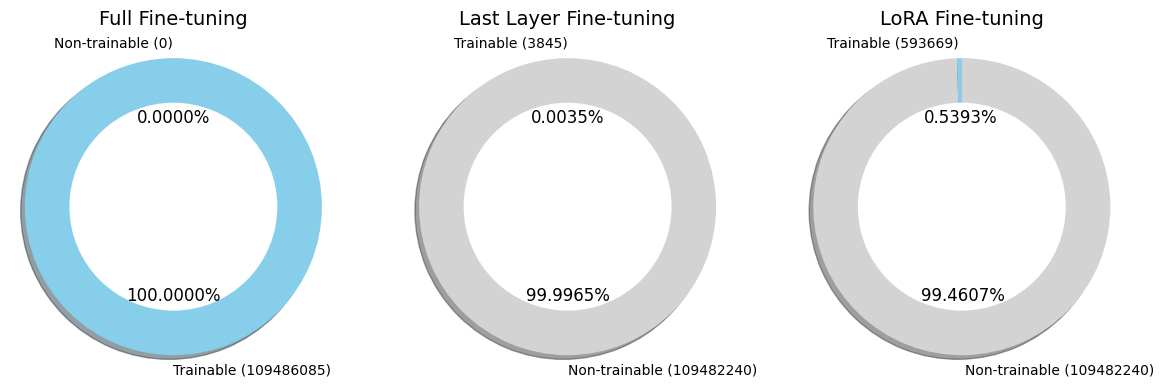

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

def create_pie_chart(ax, method, total, trainable):
    sizes = [trainable, total - trainable]
    labels = [f'Trainable ({trainable})', f'Non-trainable ({total - trainable})']
    colors = ['skyblue', 'lightgray']

    wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.4f%%', startangle=90, shadow=True)

    for text in autotexts:
        text.set_fontsize(12)

    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')
    ax.set_title(method, fontsize=14)

create_pie_chart(axs[0], 'Full Fine-tuning', total_parameters_fft, trainable_parameters_fft)
create_pie_chart(axs[1], 'Last Layer Fine-tuning', total_parameters_llft, trainable_parameters_llft)
create_pie_chart(axs[2], 'LoRA Fine-tuning', total_parameters_lora, trainable_parameters_lora)

plt.tight_layout()
plt.show()

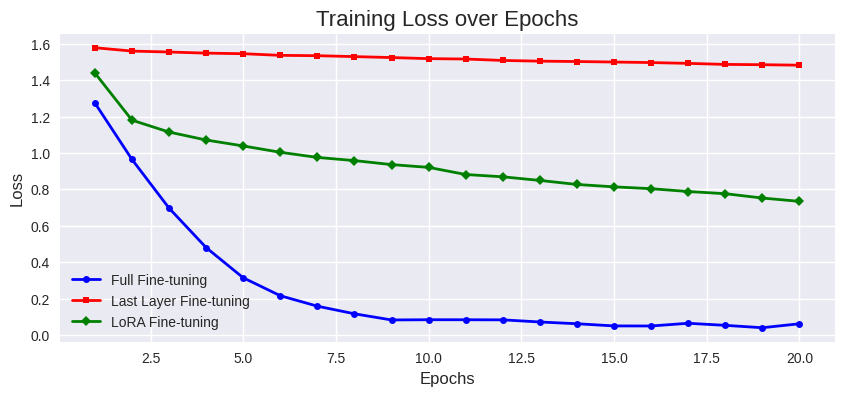

In [26]:
epochs = range(1, num_epochs + 1)

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses_fft, 'b-', label='Full Fine-tuning', linewidth=2, marker='o', markersize=5)
plt.plot(epochs, train_losses_llft, 'r-', label='Last Layer Fine-tuning', linewidth=2, marker='s', markersize=5)
plt.plot(epochs, train_losses_lora, 'g-', label='LoRA Fine-tuning', linewidth=2, marker='D', markersize=5)
plt.title('Training Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

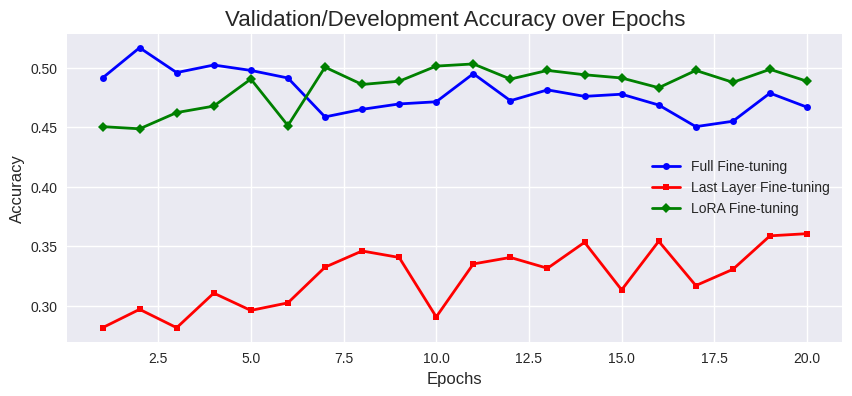

In [27]:
epochs = range(1, num_epochs + 1)

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 4))
plt.plot(epochs, dev_accuracies_fft, 'b-', label='Full Fine-tuning', linewidth=2, marker='o', markersize=5)
plt.plot(epochs, dev_accuracies_llft, 'r-', label='Last Layer Fine-tuning', linewidth=2, marker='s', markersize=5)
plt.plot(epochs, dev_accuracies_lora, 'g-', label='LoRA Fine-tuning', linewidth=2, marker='D', markersize=5)
plt.title('Validation/Development Accuracy over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

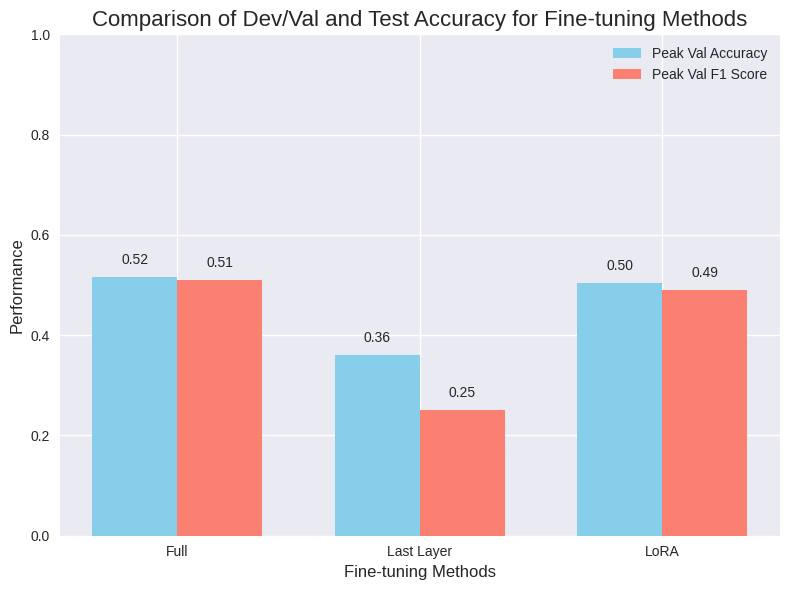

In [28]:
fine_tuning_methods = ['Full', 'Last Layer', 'LoRA']
dev_accuracy = [max(dev_accuracies_fft), max(dev_accuracies_llft), max(dev_accuracies_lora)]  # Development/Validation accuracy
test_accuracy = [max(f1_scores_fft), max(f1_scores_llft), max(f1_scores_lora)]  # Test accuracy

bar_width = 0.35
x = np.arange(len(fine_tuning_methods))

plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width/2, dev_accuracy, bar_width, label='Peak Val Accuracy', color='skyblue')
bars2 = plt.bar(x + bar_width/2, test_accuracy, bar_width, label='Peak Val F1 Score', color='salmon')

plt.title('Comparison of Dev/Val and Test Accuracy for Fine-tuning Methods', fontsize=16)
plt.xlabel('Fine-tuning Methods', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.xticks(x, fine_tuning_methods)
plt.ylim(0, 1)
plt.legend()

for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()